In [1]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback

os              : Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.31
python          : 3.9.17
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
sklearn         : 1.3.0
torch           : 2.0.1+cu117
device          : 1 gpu (['NVIDIA GeForce RTX 3060 Ti'])
cpu cores       : 8
threads per cpu : 2
RAM             : 15.57 GB
GPU memory      : [8.0] GB


# Forecast Dst

> 6- day horizon, hourly based

In [2]:
cwd = os.getcwd()
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_geo = yaml2dict('./config/dst.yaml', attrdict=True)
config_geo = config_geo.train
# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base, **config_geo})
# Add the architecture config
if config.arch_config_file is not None:
    config.arch_config_file = Path(config.arch_config_file)
    if config.arch_config_file.exists():
        config.arch = yaml2dict(config.arch_config_file, attrdict=True)
    else:
        print(f'No custom arch config found in {config.arch_config_file}')
        config.arch = AttrDict()
else:
    config.arch = AttrDict()
config

```json
{ 'add_time_channels': False,
  'arch': { 'decomposition': True,
            'individual': True,
            'padding_patch': True,
            'revin': True},
  'arch_config_file': Path('config/patchtst.yaml'),
  'arch_name': 'PatchTST',
  'bs': 1024,
  'dst': {'data_path': '../data/DST_IAGA2002.txt', 'data_url': None},
  'horizon': 144,
  'init_weights': False,
  'lookback': 432,
  'lr_max': None,
  'n_epoch': 25,
  'partial_n': 0.001,
  'seed': 42,
  'test_end_datetime': '2018-12-31',
  'test_start_datetime': '2012-10-01',
  'valid_start_datetime': '2018-01-01',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [3]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
print(config)

{'arch_name': 'PatchTST', 'arch_config_file': Path('config/patchtst.yaml'), 'bs': 1024, 'horizon': 144, 'init_weights': False, 'lookback': 432, 'lr_max': None, 'n_epoch': 25, 'partial_n': 0.001, 'seed': 42, 'test_start_datetime': '2012-10-01', 'test_end_datetime': '2018-12-31', 'valid_start_datetime': '2018-01-01', 'wandb': {'enabled': False, 'log_learner': True, 'mode': 'offline', 'group': None, 'project': 'swdf'}, 'add_time_channels': False, 'dst': {'data_url': None, 'data_path': '../data/DST_IAGA2002.txt'}, 'arch': {'decomposition': True, 'individual': True, 'padding_patch': True, 'revin': True}}


In [4]:
fname_dst = config.dst.data_path if config.dst.data_url is None else download_data(
    config.dst.data_url, fname=config.dst.data_path)
fname_dst

'../data/DST_IAGA2002.txt'

Format of the Dst data file (WDC format)

| Column | Format | Short Description                                      |
|--------|--------|--------------------------------------------------------|
| 1-3    | A3     | Index name 'DST'                                       |
| 4-5    | I2     | The last two digits of the year                        |
| 6-7    | I2     | Month                                                  |
| 8      | A1     | '*' for index                                          |
| 9-10   | I2     | Date                                                   |
| 11-12  | A2     | All spaces or may be "RR" for quick look               |
| 13     | A1     | 'X' (for index)                                        |
| 14     | A1     | Version (0: quicklook, 1: provisional, 2: final, 3 and up: corrected final or may be space) |
| 15-16  | I2     | Top two digits of the year (19 or space for 19XX, 20 from 2000) |
| 17-20  | I4     | Base value, unit 100 nT                                |
| 21-116 | 24I4   | 24 hourly values, 4 digit number, unit 1 nT, value 9999 for the missing data. First data is for the first hour of the day, and Last data is for the last hour of the day. |
| 117-120| I4     | Daily mean value, unit 1 nT. Value 9999 for the missing data. |


Format of the Dst Data file (IAGA-2002): 
https://wdc.kugi.kyoto-u.ac.jp/mdplt/format/iaga2002.html

To process the file, as given by the Kyoto provider, I used this awek script:
```
awk '!/^DATE/ && !/^ /' input.txt > output.txt
```

In [5]:
# # Read the fname_dst file as a pandas dataframe.
# # Ignore every line that starts with a space
# # Column names: YYYMMDDhhmm YYYY DDD HH MM      JD       S10   S54   M10   M54   Y10   Y54   F10   F54   AP DST  DTC SRC
# df_dst_raw = pd.read_csv(fname_dst, sep='\s{2,}|\s', names=['DATEandTIME', 'YEAR', 'DAY', 'HOUR', 'MINUTE', 'JD', 'S10', 'S54', 'M10', 'M54', 'Y10', 'Y54', 'F10', 'F54', 'AP', 'DST', 'DTC', 'SRC'])
# df_dst_raw['DATE'] = df_dst_raw.DATEandTIME.apply(str).map(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8])
# df_dst_raw['TIME'] = df_dst_raw.DATEandTIME.apply(str).map(lambda x: x[8:10] + ':' + x[10:12] + '00.000')
# df_dst_raw.dropna()
# df_dst_raw.head()

# We'll use the IAGA-2002 format
# Read the fname_dst file as a pandas dataframe.
# Ignore every line that starts with a space
# Column names: DATE       TIME         DOY     DST
df_dst_raw = pd.read_csv(fname_dst, sep='\s{2,}|\s', names=['DATE', 'TIME', 'DOY', 'DST'])
df_dst_raw.head()

,DATE,TIME,DOY,DST
0,1997-01-01,00:00:00.000,1,-5.0
1,1997-01-01,01:00:00.000,1,0.0
2,1997-01-01,02:00:00.000,1,3.0
3,1997-01-01,03:00:00.000,1,6.0
4,1997-01-01,04:00:00.000,1,9.0


In [6]:
# Check if there are any missing values
df_dst_raw.isna().sum()

DATE    0
TIME    0
DOY     0
DST     0
dtype: int64

In [7]:
# Distinct value of the column DST (classification problem?)
df_dst_raw.DST.unique().__len__()

346

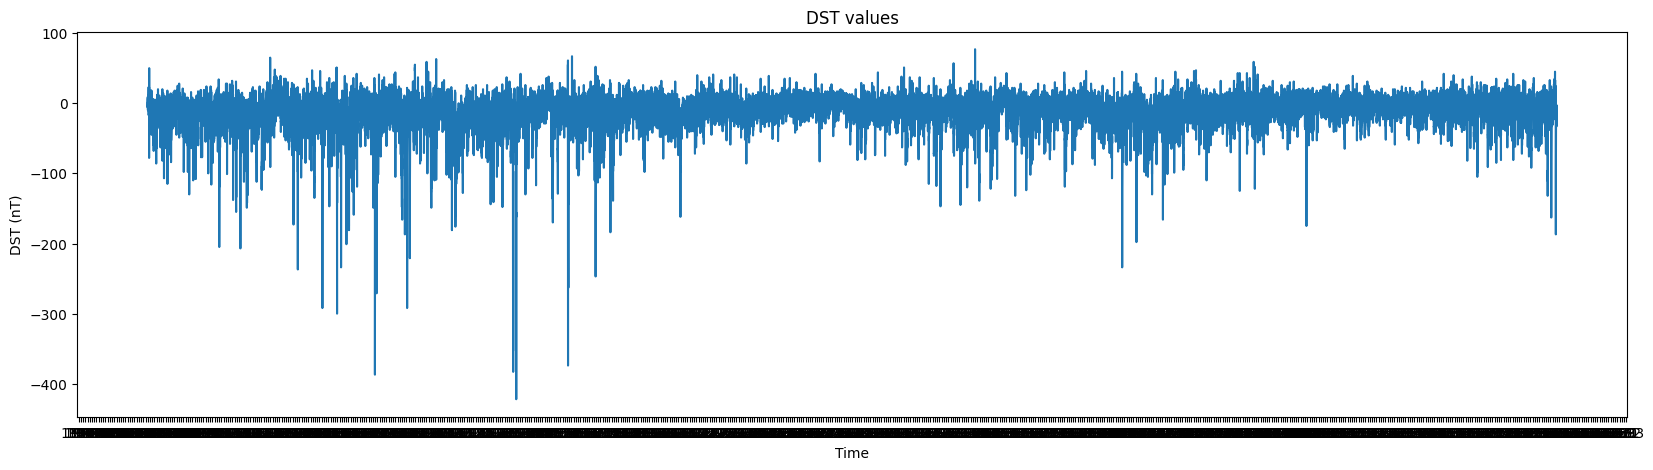

In [8]:
# hide

# Plot the DST values
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_dst_raw.DST)
ax.set_title('DST values')
ax.set_xlabel('Time')
ax.set_ylabel('DST (nT)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

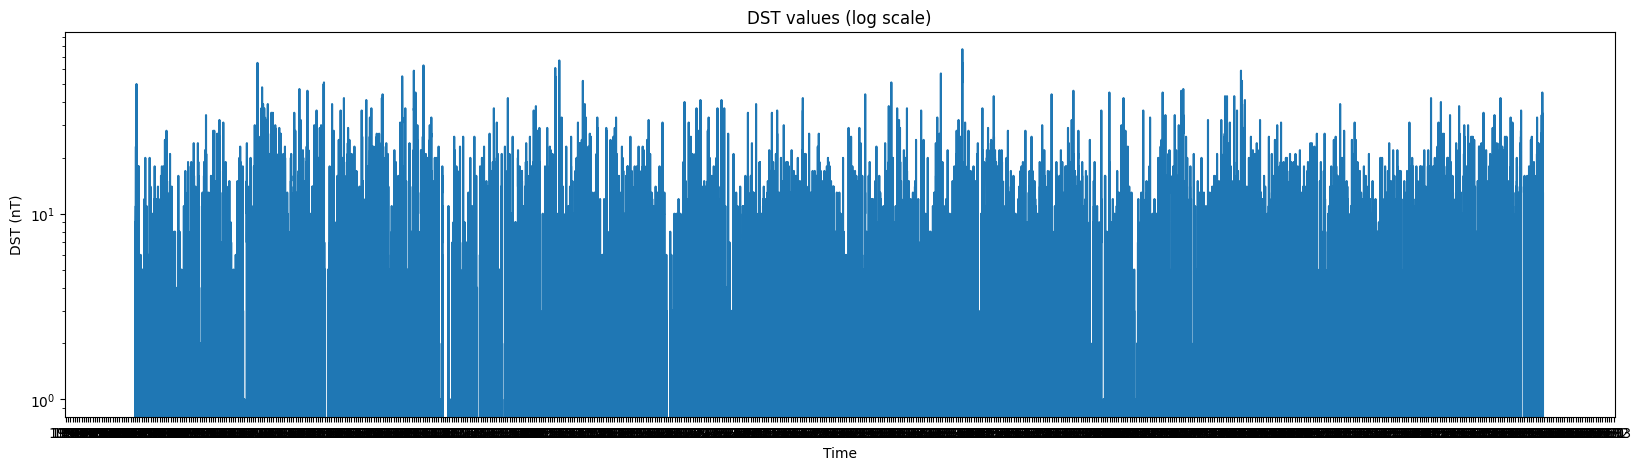

In [9]:
# hide

# Repeat the above plot but with a logarithmic scale
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_dst_raw.DST)
ax.set_title('DST values (log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('DST (nT)')
ax.set_yscale('log')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [10]:
# Merge the DATE and TIME columns into a single datetime column. Save the result
# in a new dataframe, df_dst, without the DATE and TIME columns.
df = df_dst_raw.copy()
df['datetime'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
df.drop(columns=['DATE', 'TIME'], inplace=True)
df.head()

,DOY,DST,datetime
0,1,-5.0,1997-01-01 00:00:00
1,1,0.0,1997-01-01 01:00:00
2,1,3.0,1997-01-01 02:00:00
3,1,6.0,1997-01-01 03:00:00
4,1,9.0,1997-01-01 04:00:00


In [11]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrik dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df)
df

Initial memory usage: 5.28 MB   
Final memory usage  : 3.08 MB    (-41.7%)
[Pipeline] .......... (step 1 of 1) Processing shrinker, total=   0.0s


,DOY,DST,datetime
0,1,-5.0,1997-01-01 00:00:00
1,1,0.0,1997-01-01 01:00:00
2,1,3.0,1997-01-01 02:00:00
3,1,6.0,1997-01-01 03:00:00
4,1,9.0,1997-01-01 04:00:00
...,...,...,...
230779,120,-7.0,2023-04-30 19:00:00
230780,120,-7.0,2023-04-30 20:00:00
230781,120,-6.0,2023-04-30 21:00:00
230782,120,-7.0,2023-04-30 22:00:00


In [12]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

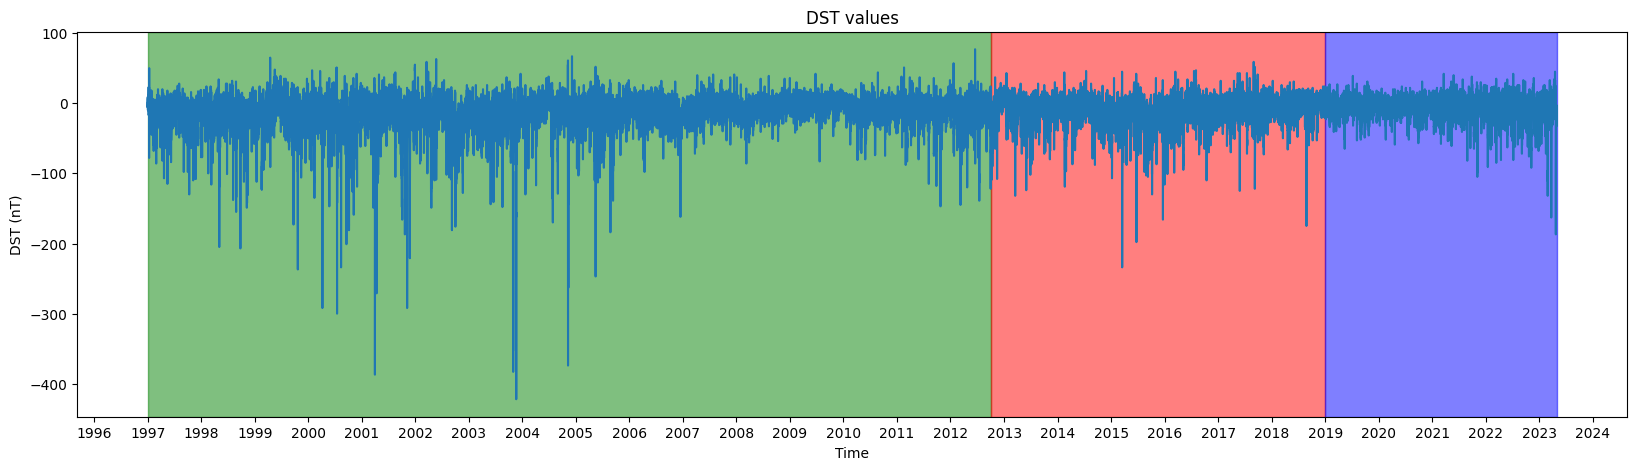

In [13]:
# hide

# Plot the variable DST, covering the different periods (training, test and validation)
# with different colors.
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df.datetime, df.DST)
ax.axvspan(df.datetime.min(), test_start_datetime, alpha=0.5, color='green')
ax.axvspan(test_start_datetime, test_end_datetime, alpha=0.5, color='red')
ax.axvspan(test_end_datetime, df.datetime.max(), alpha=0.5, color='blue')
ax.set_title('DST values')
ax.set_xlabel('Time')
ax.set_ylabel('DST (nT)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [14]:
# Splits: same as in solar flux (solfsmy) notebook

splits_ = get_forecasting_splits(df[df.datetime < valid_start_datetime], 
                             fcst_history=config.lookback, 
                             fcst_horizon=config.horizon, 
                             use_index=False, 
                             test_cutoff_datetime=test_start_datetime, 
                             show_plot=False, 
                             datetime_col='datetime')
foo = df[df.datetime >= valid_start_datetime]
bar = get_forecasting_splits(foo, config.lookback, config.horizon, valid_size=0.0, 
                             test_size=0.0, show_plot=False)
val_idxs = L(foo.index[bar[0]].tolist())

splits = (splits_[0], val_idxs, splits_[1])
splits

((#137474) [0,1,2,3,4,5,6,7,8,9...],
 (#46129) [184080,184081,184082,184083,184084,184085,184086,184087,184088,184089...],
 (#45888) [137617,137618,137619,137620,137621,137622,137623,137624,137625,137626...])

In [15]:
# Add or not add the time features
data_columns_fcst = ['DST']
data_columns_time = ['DOY']
data_columns = data_columns_fcst + data_columns_time if config.add_time_channels else data_columns_fcst
data_columns

['DST']

In [16]:
# Now that we have defined the splits for this particular experiment, we'll scale
# the data
train_split = splits[0]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)
save_object(exp_pipe, 'tmp/exp_pipe.pkl')
exp_pipe = load_object('tmp/exp_pipe.pkl')
# TODO: I don't know why but if I don't copy the dataframe df it gets modified
df_scaled = exp_pipe.fit_transform(df.copy(), scaler__idxs = train_split)
#df_scaled.set_index(datetime_col, inplace=True)
df_scaled.head()

tmp directory already exists.
Pipeline saved as tmp/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,DOY,DST,datetime
0,1,0.401267,1997-01-01 00:00:00
1,1,0.634154,1997-01-01 01:00:00
2,1,0.773886,1997-01-01 02:00:00
3,1,0.913617,1997-01-01 03:00:00
4,1,1.053349,1997-01-01 04:00:00


In [17]:
# We'll approach the time series forecasting task as a supervised learning problem. 
# Remember that tsai requires that both inputs and outputs have the following shape:
# (samples, features, steps)

# To get those inputs and outputs we're going to use a function called 
# `prepare_forecasting_data`` that applies a sliding window along the dataframe
X, y = prepare_forecasting_data(df, fcst_history=config.lookback, fcst_horizon=config.horizon, 
                                x_vars=data_columns, y_vars=data_columns_fcst)
X.shape, y.shape

((230209, 1, 432), (230209, 1, 144))

### Train

In [18]:
wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs, 
                     pipelines=[preproc_pipe, exp_pipe], arch=config.arch_name, 
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
learn.dls[0].partial_n, learn.dls[1].partial_n, learn.dls[2].partial_n

(137, None, None)

In [19]:
default_device()

device(type='cuda', index=0)

2.511886486900039e-05
#params: 20645164


epoch,train_loss,valid_loss,time
0,535.617981,216.369080,01:52
1,485.204407,208.487823,01:51
2,497.566132,215.459717,01:50
3,515.742004,238.488327,01:50
4,538.743408,263.067444,01:50
5,568.046265,313.750916,01:50
6,602.595032,475.008606,01:49
7,636.757629,452.072021,01:49
8,651.235901,469.113068,01:39
9,638.632935,686.092285,01:38


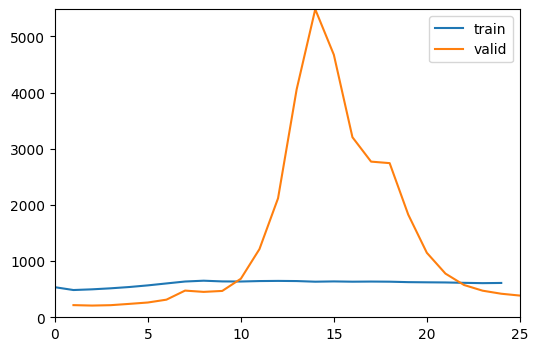

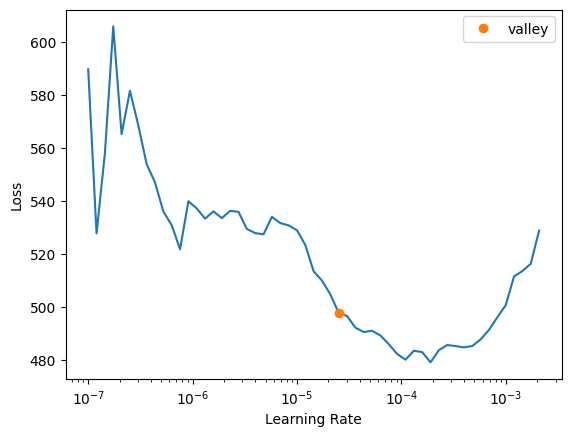

In [20]:
wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs, 
                     pipelines=[preproc_pipe, exp_pipe], arch=config.arch_name, 
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
learn.dls[0].partial_n, learn.dls[1].partial_n, learn.dls[2].partial_n
lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max
print(lr_max)
print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")
learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)

In [21]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0] 
print(valid_loss)
%store valid_loss

386.49835205078125
Stored 'valid_loss' (float)


In [22]:
# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]
print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

608.9602661132812


In [23]:
# Save everything
# learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Save locally and in wandb if online and enabled
learn.save_all(path='tmp', verbose=True) 
if run is not None and config.wandb.log_learner:
    # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
    run.log_artifact('tmp', type='learner', name='Dst')
    

Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [24]:
if run is not None:
    run.finish()